# Boston Housing Linear Regression

### Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

### Stylistics

In [2]:
%matplotlib inline
plt.style.use("dark_background")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 100)
pd.set_option("precision", 2)

### Import the Dataset

In [3]:
boston_dataset = load_boston()

boston is a bunch data type so we are presented with a dictionary like structure with keys mentioned below.


In [4]:
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

#### Data Definition

Let's look at the definition of these columns to better understand the data.

In [5]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Based on the Data Definition, we can see that we have 13 columns and the 14th one is the target variable which is the Median Value stored on  bonston_dataset.target.

Both features and target columns are separated so let's join the two columns into one DataFrame for later correlational analysis.

In [6]:
boston = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0.0,0.54,6.58,65.2,4.09,1.0,296.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0.0,0.47,6.42,78.9,4.97,2.0,242.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0.0,0.47,7.18,61.1,4.97,2.0,242.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0.0,0.46,7.00,45.8,6.06,3.0,222.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0.0,0.46,7.15,54.2,6.06,3.0,222.0,18.7,396.90,5.33


In [7]:
boston["MEDV"] = boston_dataset.target

### Data Cleaning

#### Remove NULL Values 

Let's look at if we have null values in our dataset to make sure.

In [8]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Now we are sure that every column in our dataset has no null values.

### Feature Engineering

Let's first check the correlation of each columns in our dataset.

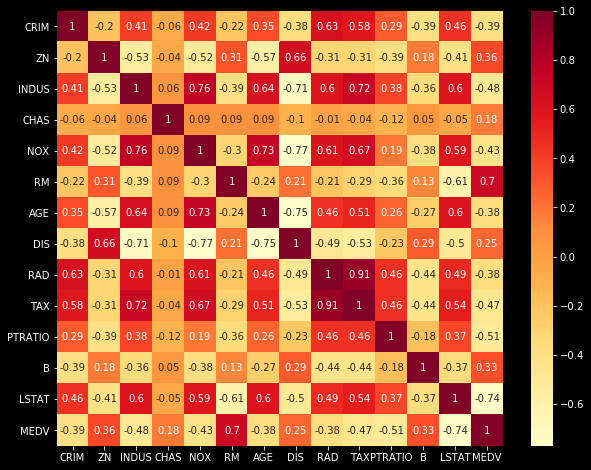

In [9]:
ax, figure = plt.subplots(figsize=(10, 8))
correlation_matrix = boston.corr().round(2)
_ = sns.heatmap(correlation_matrix, annot=True, cmap="YlOrRd")

The higher the intensity of the color is, the more it is correlated to the corresponding column. It means if the value is close to 1, the stronger they are positively correlated and the closer it is to -1 the stronger they are negatively correlated.

The goal here is to find the most highly correlated columns into the target feature `MEDV` and use it in linear regression.

Both `LSTAT` and `RM` seems to have a good feature to use with 0.7 and -0.74 being their values respectively. Let's create a Linear Regression with these.

### Linear Regression

#### Data Splitting

In [10]:
X = pd.DataFrame(boston["RM"])
y = boston_dataset.target

In [11]:
X.head()

,RM
0,6.58
1,6.42
2,7.18
3,7.00
4,7.15


In [12]:
y[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Feature Scaling

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Model Traning

In [15]:
regressor = LinearRegression().fit(X_train, y_train)

In [16]:
y_pred = regressor.predict(X_test)

#### Model Visualization

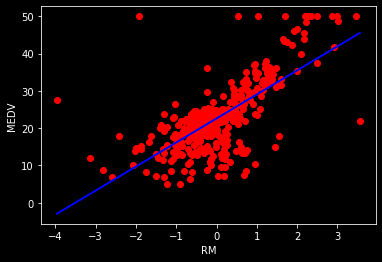

In [17]:
_ = plt.scatter(X_train, y_train, c="Red")
_ = plt.plot(X_train, regressor.predict(X_train), c="Blue")
_ = plt.xlabel("RM")
_ = plt.ylabel("MEDV")